# Image Classification Using EfficientNetB0

<a href="{https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/data}">COVID-19 Radiography Database : Kaggle</a>

In [8]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

#print("Path to dataset files:", path)

path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset"

# Data Preprocessing

In [9]:
import numpy as np
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


In [10]:
os.listdir(path)


['COVID', 'Normal']

In [11]:
class_labels = []

for item in os.listdir(path):
 # Get all the file names
 all_classes = os.listdir(path + '/' +item)
 #print(all_classes)

 # Add them to the list
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))
    #print(class_labels[:5])

In [12]:
# Build a dataframe
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

  Labels                              image
0  COVID     dataset_path/COVID/COVID-1.png
1  COVID    dataset_path/COVID/COVID-10.png
2  COVID   dataset_path/COVID/COVID-100.png
3  COVID  dataset_path/COVID/COVID-1000.png
4  COVID  dataset_path/COVID/COVID-1001.png
      Labels                               image
7227  Normal  dataset_path/Normal/Normal-995.png
7228  Normal  dataset_path/Normal/Normal-996.png
7229  Normal  dataset_path/Normal/Normal-997.png
7230  Normal  dataset_path/Normal/Normal-998.png
7231  Normal  dataset_path/Normal/Normal-999.png


In [13]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(df))

label_count = df['Labels'].value_counts()
print(label_count)

Total number of images in the dataset:  7232
Labels
COVID     3616
Normal    3616
Name: count, dtype: int64


In [14]:
import os
import cv2

path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\"
dataset_path = os.listdir("A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset")

im_size = 224
images = []
labels = []

# Number of images to select per folder
max_images_per_class = 3616

for i in dataset_path:
    data_path = os.path.join(path, i)
    filenames = os.listdir(data_path)[:max_images_per_class]  # Select only first 3616 files

    for f in filenames:
        img_path = os.path.join(data_path, f)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (im_size, im_size))
            images.append(img)
            labels.append(i)


In [15]:

#This model takes input images of shape (224, 224, 3), and the input data should range [0, 255].

images = np.array(images)

images = images.astype('float32') / 255.0
images.shape

(7232, 224, 224, 3)

In [16]:
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
y=df['Labels'].values
#print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
#print (y)

In [17]:

y=y.reshape(-1,1)

from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y) #.toarray()
print(Y[:5])
print(Y[35:])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [18]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


images, Y = shuffle(images, Y, random_state=1)


train_x, test_x, train_y, test_y = train_test_split(images, Y, test_size=0.1, random_state=415)

#inpect the shape of the training and testing.
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)


(6508, 224, 224, 3)
(6508, 2)
(724, 224, 224, 3)
(724, 2)


In [19]:
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

NUM_CLASSES = 2
IMG_SIZE = 224
size = (IMG_SIZE, IMG_SIZE)


inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))


# Using model without transfer learning

outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(inputs)

In [20]:
import os

# Set parallelism environment variables BEFORE importing TensorFlow
os.environ["TF_INTRA_OP_PARALLELISM_THREADS"] = "4"
os.environ["TF_INTER_OP_PARALLELISM_THREADS"] = "4"

import tensorflow as tf  # Import TensorFlow AFTER setting environment variables

# Verify the settings (DO NOT try to set them again)
print(f"Intra-op threads: {os.environ['TF_INTRA_OP_PARALLELISM_THREADS']}")
print(f"Inter-op threads: {os.environ['TF_INTER_OP_PARALLELISM_THREADS']}")

Intra-op threads: 4
Inter-op threads: 4


In [21]:
# Define your model (assuming inputs and outputs are already defined)
model = tf.keras.Model(inputs, outputs)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print summary
model.summary()

# Optimize Data Loading with tf.data
BATCH_SIZE = 32  # Adjust batch size based on available CPU resources
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Train the model
hist = model.fit(train_dataset, epochs=6, verbose=2)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 2)              │     4,052,133 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,052,133 (15.46 MB)

 Trainable params: 4,010,110 (15.30 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/6
204/204 - 506s - 2s/step - accuracy: 0.7185 - loss: 1.1897
Epoch 2/6
204/204 - 472s - 2s/step - accuracy: 0.8156 - loss: 0.6524
Epoch 3/6
204/204 - 471s - 2s/step - accuracy: 0.8442 - loss: 0.4066
Epoch 4/6
204/204 - 471s - 2s/step - accuracy: 0.8818 - loss: 0.3490
Epoch 5/6
204/204 - 474s - 2s/step - accuracy: 0.9050 - loss: 0.2646
Epoch 6/6
204/204 - 472s - 2s/step - accuracy: 0.9250 - loss: 0.1918


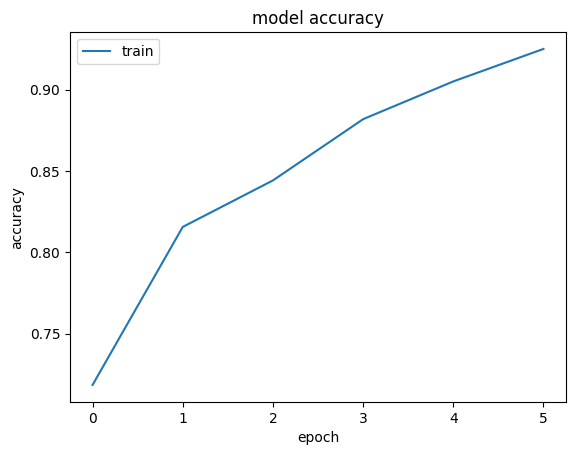

In [22]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    #plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [23]:
preds = model.evaluate(test_x, test_y)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 410ms/step - accuracy: 0.9173 - loss: 0.2104
Loss = 0.1934516429901123
Test Accuracy = 0.9281768202781677


#XAI Implementation

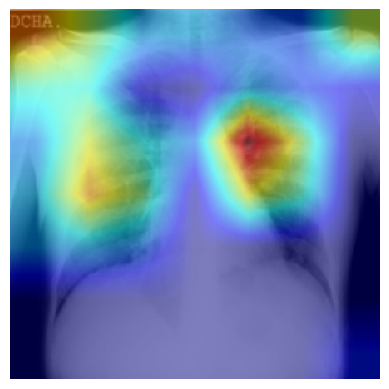

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make the GradCAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, 'top_conv')  # Replace 'block7a_project_conv' with the actual name of the last conv layer in your model

# Resize the heatmap to match the original image dimensions
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(cv2.cvtColor(img_array[0].astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, heatmap, 0.5, 0)

# Save and display the heatmap
cv2.imwrite('heatmap.jpg', superimposed_img)

# Display the image in the notebook
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

c:\Users\malli\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step


  0%|          | 0/98 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


PartitionExplainer explainer: 2it [00:11, 11.92s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.596256008368777e-12..2.70992299441857e-12].


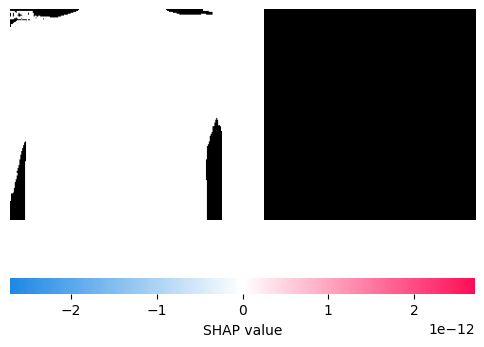

In [50]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define a prediction function
def predict_fn(images):
    return model.predict(images)

# Create a masker
masker = shap.maskers.Image("inpaint_telea", img_array[0].shape)

# Create an explainer
explainer = shap.Explainer(predict_fn, masker)

# Calculate SHAP values
shap_values = explainer(img_array[:1], max_evals=100, batch_size=50)

# Plot the SHAP values
shap.image_plot(shap_values.values, img_array[:1])

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


  1%|          | 10/1000 [00:00<00:25, 39.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


  2%|▏         | 20/1000 [00:00<00:22, 43.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


  3%|▎         | 30/1000 [00:00<00:21, 46.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


  4%|▍         | 40/1000 [00:00<00:20, 46.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


  5%|▌         | 50/1000 [00:01<00:20, 46.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


  6%|▌         | 60/1000 [00:01<00:20, 45.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


  7%|▋         | 70/1000 [00:01<00:20, 44.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


  8%|▊         | 80/1000 [00:01<00:20, 45.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


  9%|▉         | 90/1000 [00:01<00:20, 44.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 10%|█         | 100/1000 [00:02<00:19, 45.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 11%|█         | 110/1000 [00:02<00:19, 45.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 12%|█▏        | 120/1000 [00:02<00:19, 45.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 13%|█▎        | 130/1000 [00:02<00:18, 46.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 14%|█▍        | 140/1000 [00:03<00:18, 46.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 15%|█▌        | 150/1000 [00:03<00:18, 46.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


 16%|█▌        | 160/1000 [00:03<00:18, 44.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 17%|█▋        | 170/1000 [00:03<00:18, 45.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 18%|█▊        | 180/1000 [00:03<00:17, 45.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 19%|█▉        | 190/1000 [00:04<00:17, 45.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 20%|██        | 200/1000 [00:04<00:17, 46.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


 21%|██        | 210/1000 [00:04<00:17, 45.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 22%|██▏       | 220/1000 [00:04<00:17, 45.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 23%|██▎       | 230/1000 [00:05<00:16, 45.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 24%|██▍       | 240/1000 [00:05<00:16, 46.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


 25%|██▌       | 250/1000 [00:05<00:16, 45.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


 26%|██▌       | 260/1000 [00:05<00:16, 44.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


 27%|██▋       | 270/1000 [00:05<00:16, 44.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 28%|██▊       | 280/1000 [00:06<00:15, 46.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 29%|██▉       | 290/1000 [00:06<00:15, 46.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 30%|███       | 300/1000 [00:06<00:14, 46.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


 31%|███       | 310/1000 [00:06<00:15, 44.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 32%|███▏      | 320/1000 [00:07<00:15, 45.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 33%|███▎      | 330/1000 [00:07<00:14, 45.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


 34%|███▍      | 340/1000 [00:07<00:14, 46.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


 35%|███▌      | 350/1000 [00:07<00:14, 46.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


 36%|███▌      | 360/1000 [00:07<00:14, 45.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 37%|███▋      | 370/1000 [00:08<00:13, 46.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 38%|███▊      | 380/1000 [00:08<00:13, 46.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 39%|███▉      | 390/1000 [00:08<00:12, 47.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 40%|████      | 400/1000 [00:08<00:12, 48.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


 41%|████      | 410/1000 [00:08<00:12, 45.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 42%|████▏     | 420/1000 [00:09<00:12, 45.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 43%|████▎     | 430/1000 [00:09<00:12, 45.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 44%|████▍     | 440/1000 [00:09<00:12, 46.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 45%|████▌     | 450/1000 [00:09<00:11, 46.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 46%|████▌     | 460/1000 [00:10<00:11, 45.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


 47%|████▋     | 470/1000 [00:10<00:11, 45.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


 48%|████▊     | 480/1000 [00:10<00:11, 45.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


 49%|████▉     | 490/1000 [00:10<00:11, 45.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


 50%|█████     | 500/1000 [00:10<00:10, 46.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 51%|█████     | 510/1000 [00:11<00:10, 46.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 52%|█████▏    | 520/1000 [00:11<00:10, 47.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 53%|█████▎    | 530/1000 [00:11<00:09, 47.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 54%|█████▍    | 540/1000 [00:11<00:09, 46.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


 55%|█████▌    | 550/1000 [00:11<00:09, 45.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


 56%|█████▌    | 560/1000 [00:12<00:09, 45.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 57%|█████▋    | 570/1000 [00:12<00:09, 45.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


 58%|█████▊    | 580/1000 [00:12<00:09, 45.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 59%|█████▉    | 590/1000 [00:12<00:08, 46.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 60%|██████    | 600/1000 [00:13<00:08, 46.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 61%|██████    | 610/1000 [00:13<00:08, 46.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


 62%|██████▏   | 620/1000 [00:13<00:07, 47.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 63%|██████▎   | 630/1000 [00:13<00:07, 48.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 64%|██████▍   | 640/1000 [00:13<00:07, 48.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 65%|██████▌   | 650/1000 [00:14<00:07, 48.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 66%|██████▌   | 660/1000 [00:14<00:06, 48.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 67%|██████▋   | 670/1000 [00:14<00:06, 49.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 68%|██████▊   | 680/1000 [00:14<00:06, 48.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 69%|██████▉   | 690/1000 [00:14<00:06, 48.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 70%|███████   | 700/1000 [00:15<00:06, 49.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 71%|███████   | 710/1000 [00:15<00:05, 49.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 72%|███████▏  | 720/1000 [00:15<00:05, 49.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 73%|███████▎  | 730/1000 [00:15<00:05, 49.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 74%|███████▍  | 740/1000 [00:15<00:05, 49.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 75%|███████▌  | 750/1000 [00:16<00:05, 48.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 76%|███████▌  | 760/1000 [00:16<00:04, 48.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 77%|███████▋  | 770/1000 [00:16<00:04, 48.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 78%|███████▊  | 780/1000 [00:16<00:04, 48.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 79%|███████▉  | 790/1000 [00:16<00:04, 49.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 80%|████████  | 800/1000 [00:17<00:04, 49.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 81%|████████  | 810/1000 [00:17<00:03, 49.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 82%|████████▏ | 820/1000 [00:17<00:03, 48.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


 83%|████████▎ | 830/1000 [00:17<00:03, 48.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 84%|████████▍ | 840/1000 [00:17<00:03, 49.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 85%|████████▌ | 850/1000 [00:18<00:03, 49.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


 86%|████████▌ | 860/1000 [00:18<00:02, 48.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 87%|████████▋ | 870/1000 [00:18<00:02, 48.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


 88%|████████▊ | 880/1000 [00:18<00:02, 47.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 89%|████████▉ | 890/1000 [00:19<00:02, 48.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 90%|█████████ | 900/1000 [00:19<00:02, 49.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


 91%|█████████ | 910/1000 [00:19<00:01, 49.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 92%|█████████▏| 920/1000 [00:19<00:01, 49.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 93%|█████████▎| 930/1000 [00:19<00:01, 49.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 94%|█████████▍| 940/1000 [00:20<00:01, 49.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


 95%|█████████▌| 950/1000 [00:20<00:01, 48.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 96%|█████████▌| 960/1000 [00:20<00:00, 48.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


 97%|█████████▋| 970/1000 [00:20<00:00, 49.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 98%|█████████▊| 980/1000 [00:20<00:00, 48.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


 99%|█████████▉| 990/1000 [00:21<00:00, 49.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


100%|██████████| 1000/1000 [00:21<00:00, 47.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..126.5].


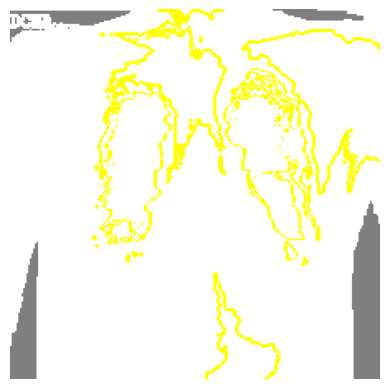

In [51]:
import lime
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Load the image
img_path = "A:\\GVSU Semester 5\\PSM Internship\\Covid-19\\COVID-19_Radiography_Dataset\\COVID\\COVID-1000.png"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Define the prediction function
def predict_fn(images):
    return model.predict(images)

# Create a LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(img_array[0].astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Show the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.axis('off')
plt.show()